In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'word_embedding_dimension': 100,
        'conv_num_filters': 300,
        'conv_windows_size': 3,
        'max_pool_seq_len': MAX_LEN,
        'sent_embedding_dimension': 128,
        'dropout_rate': 0.2,
        'hidden_dimension': 200,
        'output_dimension': 1}

In [7]:
class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()
        
        self.conv = layers.Conv1D(kargs['conv_num_filters'],
                                 kargs['conv_windows_size'],
                                 activation='relu', padding='same')
        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        self.dense = layers.Dense(kargs['sent_embedding_dimension'], activation='relu')
        
    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)

In [8]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        self.word_embedding = layers.Embedding(kargs['vocab_size'] + 1,
                                              kargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = layers.Dense(kargs['hidden_dimension'], activation='relu')
        self.logit = layers.Dense(kargs['output_dimension'], activation='sigmoid')
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        x1, x2 = x
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x, h_x], -1)
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)
        
        return self.logit(e_x)

In [9]:
model = SentenceSimilarityModel(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [10]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)  # 얘를 빼서 dir이 안만들어졌었음, 이거 코딩 다시해서 돌림
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=True)

./data_out/cnn_similarity -- Folder already exists 



In [11]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
263/263 [==============================] - 19s 50ms/step - loss: 0.5485 - accuracy: 0.7184 - val_loss: 0.4908 - val_accuracy: 0.7340

Epoch 00001: val_accuracy improved from -inf to 0.73400, saving model to ./data_out/cnn_similarity\weights.h5
Epoch 2/100
263/263 [==============================] - 13s 48ms/step - loss: 0.4440 - accuracy: 0.7916 - val_loss: 0.4838 - val_accuracy: 0.7445

Epoch 00002: val_accuracy improved from 0.73400 to 0.74451, saving model to ./data_out/cnn_similarity\weights.h5
Epoch 3/100
263/263 [==============================] - 12s 46ms/step - loss: 0.3540 - accuracy: 0.8401 - val_loss: 0.5251 - val_accuracy: 0.7646

Epoch 00003: val_accuracy improved from 0.74451 to 0.76465, saving model to ./data_out/cnn_similarity\weights.h5
Epoch 4/100
263/263 [==============================] - 12s 46ms/step - loss: 0.2708 - accuracy: 0.8824 - val_loss: 0.5779 - val_accuracy: 0.7829

Epoch 00004: val_accuracy improved from 0.76465 to 0.78290, saving model to ./da

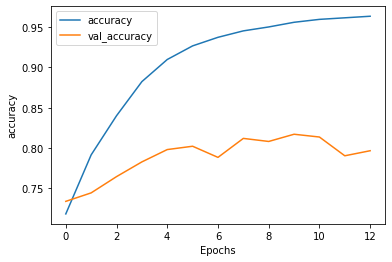

In [14]:
plot_graphs(history, 'accuracy')

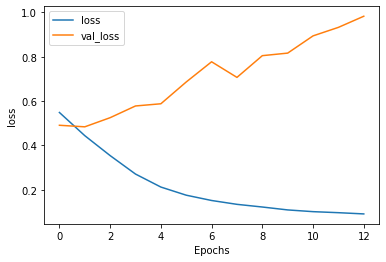

In [13]:
plot_graphs(history, 'loss')

In [ ]:
# 다했으면 캐글에 올려서 채점

In [15]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [16]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [17]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [18]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(DATA_OUT_PATH + "cnn_predict.csv", index=False, quoting=3)

In [ ]:
# 캐글 주소
# https://www.kaggle.com/c/quora-question-pairs